In [2]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from datetime import datetime
from math import radians, cos, sin, sqrt, atan2, degrees
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [53]:
df = pd.read_csv("ais.csv")
df

,lat,lon,date,ID
0,38.10147,-122.26952,2020-12-31T00:00:00,366989380
1,32.71527,-117.17972,2020-12-31T00:00:00,366685950
2,41.66363,-87.58109,2020-12-31T00:00:00,367463740
3,32.34337,-117.63240,2020-12-31T00:00:00,354277000
4,33.46530,-118.48131,2020-12-31T00:00:00,376162280
...,...,...,...,...
1048570,40.63305,-74.20236,2020-12-31T03:42:13,636013274
1048571,34.18450,-77.95667,2020-12-31T03:42:13,308695000
1048572,41.14392,-73.89121,2020-12-31T03:42:13,338862000
1048573,17.99635,-66.77203,2020-12-31T03:42:13,368669000


In [54]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
# Sort DataFrame by date
df = df.sort_values(by=['ID','date'])


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 5305 to 1039725
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   lat     1048575 non-null  float64       
 1   lon     1048575 non-null  float64       
 2   date    1048575 non-null  datetime64[ns]
 3   ID      1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 40.0 MB


In [35]:
df=df.dropna()

In [44]:
# Helper function to calculate Haversine distance between two lat/lon pairs
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles.
    return c * r

# Function to calculate the bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = sin(dlon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    initial_bearing = atan2(x, y)
    initial_bearing = degrees(initial_bearing)
    bearing = (initial_bearing + 360) % 360
    return bearing


# Compute shifted latitude, longitude, and date for difference calculation
df['shifted_lat'] = df.groupby('ID')['lat'].shift()
df['shifted_lon'] = df.groupby('ID')['lon'].shift()
df['shifted_date'] = df.groupby('ID')['date'].shift()

# Initialize columns for distance, speed, and direction
df['distance_km'] = 0.0
df['speed_kmh'] = 0.0
df['direction'] = 0.0

# Iterate over DataFrame rows to calculate distance, speed and direction
for index, row in df.iterrows():
    if pd.notnull(row['shifted_date']) and pd.notnull(row['shifted_lat']) and pd.notnull(row['shifted_lon']):
        # Calculate distance
        distance = haversine(row['lon'], row['lat'], row['shifted_lon'], row['shifted_lat'])
        df.at[index, 'distance_km'] = distance
        
        # Calculate time difference in hours
        time_diff_hours = (row['date'] - row['shifted_date']).total_seconds() / 3600
        if time_diff_hours > 0:
            # Calculate speed
            speed = distance / time_diff_hours
            df.at[index, 'speed_kmh'] = speed
        
        # Calculate direction
        direction = calculate_bearing(row['shifted_lat'], row['shifted_lon'], row['lat'], row['lon'])
        df.at[index, 'direction'] = direction

# Drop the temporary shifted columns
df.drop(columns=['shifted_lat', 'shifted_lon', 'shifted_date'], inplace=True)

# You can now display the DataFrame or do further analysis
df.head()



,lat,lon,date,ID,distance_km,speed_kmh,direction
5305,21.31639,-157.87734,2020-12-31 00:00:59,0,0.0,0.0,0.0
20935,21.31639,-157.87734,2020-12-31 00:04:02,0,0.0,0.0,0.0
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,0.0,0.0,0.0
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,0.0,0.0,0.0
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,0.0,0.0,0.0


In [45]:
df.tail()

,lat,lon,date,ID,distance_km,speed_kmh,direction
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,0.000926,0.018624,270.000003
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,0.002160,0.010369,239.020423
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,0.001447,0.014471,39.787930
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,0.000926,0.009209,89.999997
1039725,33.61133,-117.92657,2020-12-31 03:40:19,1072211352,0.000926,0.018729,270.000003


In [31]:
df

,lat,lon,date,ID,distance,speed,direction
5305,21.31639,-157.87734,2020-12-31 00:00:59,0,NaN,NaN,NaN
20935,21.31639,-157.87734,2020-12-31 00:04:02,0,0.0,0.0,NaN
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,NaN,NaN,NaN
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,NaN,NaN,NaN
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,NaN,NaN,NaN
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,NaN,NaN,NaN
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,NaN,NaN,NaN
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,NaN,NaN,NaN


In [59]:
# Assuming df is your DataFrame and that 'date' is already a datetime64 type.

# Calculate the diffs required for the operations
df['shifted_lat'] = df.groupby('ID')['lat'].shift()
df['shifted_lon'] = df.groupby('ID')['lon'].shift()
df['time_diff'] = df['date'].diff().dt.total_seconds().div(60)  # Time diff in hours

# Vectorized implementation of the Haversine formula
def vectorized_haversine(lon1, lat1, lon2, lat2):
    # Convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Calculate distances using the vectorized function
df['distance_km'] = vectorized_haversine(df['shifted_lon'], df['shifted_lat'], df['lon'], df['lat'])

# Calculate speeds: distance/time
df['speed_kmh'] = df['distance_km'] / df['time_diff']  # Speed in km/h

# Ensure we're not dividing by zero
df['speed_kmh'] = df['speed_kmh'].replace(np.inf, np.nan)

# Define a vectorized function for bearing
def vectorized_bearing(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Bearing calculation
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    # Convert from radians to degrees and adjust to 0-360 scale
    return np.degrees(initial_bearing) % 360

# Calculate bearing using the vectorized function
df['direction'] = np.where(pd.notna(df['shifted_lon']), 
                         vectorized_bearing(df['shifted_lat'], df['shifted_lon'], df['lat'], df['lon']), 
                         np.nan)

# Clean up: drop temporary columns and NA values that arose from shifting
df.drop(['shifted_lat', 'shifted_lon'], axis=1, inplace=True)
df.dropna(subset=['direction', 'speed_kmh', 'distance_km'], inplace=True)

In [60]:
df

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.000000,0.000000,0.000000
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.000000,0.000000,0.000000
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.000000,0.000000,0.000000
78504,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.000000,0.000000,0.000000
93409,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,2.983333,0.000926,0.000310,270.000003
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,12.500000,0.002160,0.000173,239.020423
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,6.000000,0.001447,0.000241,39.787930
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,6.033333,0.000926,0.000153,89.999997


In [61]:
column_names = df.columns.tolist()
column_names

['lat',
 'lon',
 'date',
 'ID',
 'time_diff',
 'distance_km',
 'speed_kmh',
 'direction']

In [65]:
df[df['ID'] == 0]

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.0,0.0,0.0
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.0,0.0,0.0
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.0,0.0,0.0
78504,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.0,0.0,0.0
93409,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
981448,21.31639,-157.87735,2020-12-31 03:27:45,0,3.050000,0.0,0.0,0.0
995683,21.31639,-157.87735,2020-12-31 03:30:47,0,3.033333,0.0,0.0,0.0
1009900,21.31639,-157.87735,2020-12-31 03:33:50,0,3.050000,0.0,0.0,0.0
1023791,21.31639,-157.87735,2020-12-31 03:36:52,0,3.033333,0.0,0.0,0.0


In [98]:
import folium
from folium.plugins import MarkerCluster

# Function to plot data on an online folium map.
def plot_on_online_folium_map(df, id_value):
    # Filter the dataset for the ID.
    df_filtered = df[df['ID'] == id_value]
    
    # Check if there's data to plot.
    if df_filtered.empty:
        print(f"No data found for ID {id_value}")
        return None

    # Create a Map instance
    m = folium.Map(location=[df_filtered['lat'].mean(), df_filtered['lon'].mean()],
                   zoom_start=13)
    
    # Create and add a MarkerCluster to the map.
    marker_cluster = MarkerCluster().add_to(m)

    # Add markers to the MarkerCluster
    for idx, row in df_filtered.iterrows():
        folium.Marker(location=[row['lat'], row['lon']], popup=f'ID: {id_value}, Index: {idx}').add_to(marker_cluster)
    
    # Display the map
    return m

# Replace 'your_id' with the actual ID value you want to plot
# Plot the data for the ID on an online folium map.
online_map = plot_on_online_folium_map(df, 0)

# If running in a Jupyter notebook environment, display the map inline
online_map

In [91]:
df["ID"].unique().tolist()

[0,
 12,
 270995,
 368926,
 507027,
 737255,
 3660489,
 3660503,
 9110192,
 12345678,
 36690000,
 99150794,
 122292919,
 123456789,
 155017179,
 200000000,
 205706000,
 205760000,
 207832820,
 209016000,
 209162000,
 209414000,
 209438000,
 209504000,
 209513000,
 209550000,
 209641000,
 209729000,
 209862000,
 209933000,
 210102000,
 210296000,
 210347000,
 210520410,
 210562000,
 210638000,
 210886000,
 210959000,
 211002010,
 211111111,
 211331640,
 211433000,
 211705870,
 211744000,
 211779000,
 211839000,
 212001111,
 212040000,
 212254000,
 212348000,
 212384000,
 212438000,
 212452000,
 214182695,
 214182782,
 215000394,
 215004000,
 215035000,
 215126000,
 215131000,
 215181000,
 215193000,
 215197000,
 215233000,
 215240000,
 215251000,
 215322000,
 215434000,
 215464000,
 215532000,
 215558000,
 215677000,
 215800000,
 215871000,
 218063000,
 218352000,
 218441000,
 218643000,
 219028015,
 219028040,
 219056000,
 219151000,
 219208000,
 219256000,
 219349000,
 219353000,
 219

In [100]:
# df.to_csv("ais_fixed1.csv",index=False)

In [59]:
df2 = pd.read_csv("ais_fixed1.csv")
df = df2.copy()

In [60]:
df2

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction
0,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.000000,0.000000,0.000000
1,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.000000,0.000000,0.000000
2,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.000000,0.000000,0.000000
3,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.000000,0.000000,0.000000
4,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1027261,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,2.983333,0.000926,0.000310,270.000003
1027262,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,12.500000,0.002160,0.000173,239.020423
1027263,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,6.000000,0.001447,0.000241,39.787930
1027264,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,6.033333,0.000926,0.000153,89.999997


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027266 entries, 0 to 1027265
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   lat          1027266 non-null  float64
 1   lon          1027266 non-null  float64
 2   date         1027266 non-null  object 
 3   ID           1027266 non-null  int64  
 4   time_diff    1027266 non-null  float64
 5   distance_km  1027266 non-null  float64
 6   speed_kmh    1027266 non-null  float64
 7   direction    1027266 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 62.7+ MB


In [5]:
df.isnull().sum()

lat            0
lon            0
date           0
ID             0
time_diff      0
distance_km    0
speed_kmh      0
direction      0
dtype: int64

In [9]:
df.isin([np.inf, -np.inf]).sum()

lat            0
lon            0
date           0
ID             0
time_diff      0
distance_km    0
speed_kmh      0
direction      0
lat_prev       0
lon_prev       0
dtype: int64

In [72]:

# Add a new column to mark the start and end points
df['StartPoint'] = 0
df['EndPoint'] = 0

# Identify start and end indices for each unique ID
grouped_indices = df.groupby('ID').apply(lambda group: (group.index[0], group.index[-1]))

# Mark the start and end points in the dataframe
for start_index, end_index in grouped_indices:
    df.at[start_index, 'StartPoint'] = 1
    df.at[end_index, 'EndPoint'] = 1

In [23]:
df.query('ID==0')

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction,StartPoint,EndPoint
0,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.0,0.0,0.0,1,0
1,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.0,0.0,0.0,0,0
2,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.0,0.0,0.0,0,0
3,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.0,0.0,0.0,0,0
4,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
66,21.31639,-157.87735,2020-12-31 03:27:45,0,3.050000,0.0,0.0,0.0,0,0
67,21.31639,-157.87735,2020-12-31 03:30:47,0,3.033333,0.0,0.0,0.0,0,0
68,21.31639,-157.87735,2020-12-31 03:33:50,0,3.050000,0.0,0.0,0.0,0,0
69,21.31639,-157.87735,2020-12-31 03:36:52,0,3.033333,0.0,0.0,0.0,0,0


In [11]:
df_small = df[:10000]
# Assuming you have a 'timestamp' or 'datetime' column in your dataset
df_small['date'] = pd.to_datetime(df_small['date'])
df_small['date'] = df_small['date'].astype(np.int64) // 10**9
# Sort the DataFrame by ID and timestamp
df_small.sort_values(['ID', 'date'], inplace=True)

# Create features for time-series prediction
df_small['lat_prev'] = df_small.groupby('ID')['lat'].shift(1)
df_small['lon_prev'] = df_small.groupby('ID')['lon'].shift(1)

# Drop rows with missing values introduced by shifting
df_small.dropna(subset=['lat_prev', 'lon_prev'], inplace=True)

# Create target variables
y_lat = df_small['lat']
y_lon = df_small['lon']

# Select features for prediction
features = ['lat', 'lon', 'date', 'ID', 'time_diff', 'distance_km', 'speed_kmh', 'direction']
X = df_small[features]

# Split the dataset
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest Regressors for latitude and longitude
lat_regressor = RandomForestRegressor(random_state=42)
lon_regressor = RandomForestRegressor(random_state=42)

lat_regressor.fit(X_train_scaled, y_lat_train)
lon_regressor.fit(X_train_scaled, y_lon_train)

# Make predictions on the test set
y_lat_pred = lat_regressor.predict(X_test_scaled)
y_lon_pred = lon_regressor.predict(X_test_scaled)

# Evaluate the performance (you can use different metrics based on your needs)
mse_lat = mean_squared_error(y_lat_test, y_lat_pred)
mse_lon = mean_squared_error(y_lon_test, y_lon_pred)

print(f'Mean Squared Error for Latitude: {mse_lat}')
print(f'Mean Squared Error for Longitude: {mse_lon}')

C:\Users\o.kazemi\AppData\Local\Temp\ipykernel_11492\3296803347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['date'] = pd.to_datetime(df_small['date'])
C:\Users\o.kazemi\AppData\Local\Temp\ipykernel_11492\3296803347.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['date'] = df_small['date'].astype(np.int64) // 10**9
C:\Users\o.kazemi\AppData\Local\Temp\ipykernel_11492\3296803347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

Mean Squared Error for Latitude: 7.2478667299618385e-06
Mean Squared Error for Longitude: 1.736678477304488e-05


In [29]:
df.sample(10)

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction,StartPoint,EndPoint
638192,37.69967,-122.62711,2020-12-31 00:12:51,367566960,1.533333,0.337196,0.219911,18.246212,0,0
613890,40.70461,-73.97243,2020-12-31 00:33:57,367531710,1.150000,0.000000,0.000000,0.000000,0,0
558320,30.29193,-91.22451,2020-12-31 03:31:44,367459210,1.150000,0.002219,0.001930,59.926529,0,0
812196,29.64263,-94.85683,2020-12-31 01:02:34,368000390,1.183333,0.001473,0.001245,139.005207,0,0
993554,27.68597,-96.81379,2020-12-31 03:30:40,538007746,1.183333,0.366776,0.309951,139.280746,0,0
555659,29.43940,-94.70089,2020-12-31 01:52:12,367456820,1.166667,0.178204,0.152746,48.113319,0,0
31569,30.20926,-91.03658,2020-12-31 00:58:33,271044090,3.000000,0.000961,0.000320,270.000003,0,0
47583,32.37201,-80.69294,2020-12-31 00:24:27,311050300,3.000000,0.004828,0.001609,337.105920,0,0
124436,37.86410,-122.49130,2020-12-31 00:19:01,338117512,3.050000,0.003449,0.001131,345.256524,0,0
986605,17.97310,-65.70654,2020-12-31 02:09:40,538005095,1.166667,0.047809,0.040979,232.791591,0,0


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame named df
# Assuming 'date' column is in datetime format

# Create lagged features
df['lag_speed_kmh'] = df.groupby(['ID', 'date'])['speed_kmh'].shift(1)
df['lag_distance_km'] = df.groupby(['ID', 'date'])['distance_km'].shift(1)
df['lag_direction'] = df.groupby(['ID', 'date'])['direction'].shift(1)

# Drop rows with NaN values due to lag
df = df.dropna()

# Initialize an empty DataFrame to store predictions
predictions_df = pd.DataFrame()

# Iterate over unique groups (ID, date)
for (ID, date), group in df.groupby(['ID', 'date']):
    X = group[['lag_speed_kmh', 'lag_distance_km', 'lag_direction']]
    y = group['speed_kmh']

    # Ensure that the group has enough samples for the train-test split
    if len(group) < 2:
        continue

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Use the model to predict on the test set
    y_pred = model.predict(X_test)

    # Store the predictions in a DataFrame
    prediction_result = group.loc[X_test.index, ['lat', 'lon', 'date', 'ID', 'time_diff']]
    prediction_result['predicted_speed_kmh'] = y_pred  # <-- Corrected column name
    predictions_df = pd.concat([predictions_df, prediction_result])
    

# Calculate the Mean Squared Error
mse = mean_squared_error(df['speed_kmh'], predictions_df['predicted_speed_kmh'])
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted values
plt.scatter(df['speed_kmh'], predictions_df['predicted_speed_kmh'])
plt.xlabel('Actual Speed (km/h)')
plt.ylabel('Predicted Speed (km/h)')
plt.title('Actual vs Predicted Speed')
plt.show()


KeyError: 'predicted_speed_kmh'

In [69]:
df

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction,lat_lag1,lat_lag2,...,time_diff_lag3,distance_km_lag1,distance_km_lag2,distance_km_lag3,speed_kmh_lag1,speed_kmh_lag2,speed_kmh_lag3,direction_lag1,direction_lag2,direction_lag3
0,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.000000,0.000000,0.000000,21.31639,NaN,...,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
2,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.000000,0.000000,0.000000,21.31639,21.31639,...,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
3,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.000000,0.000000,0.000000,21.31639,21.31639,...,3.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.000000,0.000000,0.000000,21.31639,21.31639,...,3.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,30.51975,-129.23837,2020-12-31 01:34:41,228354600,1.100000,0.607102,0.551911,112.392077,30.52183,30.52387,...,1.083333,0.590344,0.608765,0.590728,0.536677,0.553423,0.545287,112.595517,113.463667,113.635397
9996,30.51762,-129.23262,2020-12-31 01:35:48,228354600,1.116667,0.599559,0.536918,113.266550,30.51975,30.52183,...,1.100000,0.607102,0.590344,0.608765,0.551911,0.536677,0.553423,112.392077,112.595517,113.463667
9997,30.51537,-129.22693,2020-12-31 01:36:54,228354600,1.100000,0.599737,0.545215,114.654221,30.51762,30.51975,...,1.100000,0.599559,0.607102,0.590344,0.536918,0.551911,0.536677,113.266550,112.392077,112.595517
9998,30.51317,-129.22135,2020-12-31 01:37:59,228354600,1.083333,0.587852,0.542633,114.589703,30.51537,30.51762,...,1.100000,0.599737,0.599559,0.607102,0.545215,0.536918,0.551911,114.654221,113.266550,112.392077


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Assuming df is your DataFrame with columns: lat, lon, date, ID, time_diff, distance_km, speed_kmh, direction, StartPoint, EndPoint

# Sort data by ID and date
df.sort_values(by=['ID', 'date'], inplace=True)

# Feature engineering - you may need to customize this part based on your specific features and requirements
# For simplicity, we're using only a few features here.
features = ['lat', 'lon', 'time_diff', 'distance_km', 'speed_kmh', 'direction','StartPoint', 'EndPoint']
target_columns = ['lat', 'lon', 'time_diff', 'distance_km', 'speed_kmh', 'direction', 'StartPoint', 'EndPoint']

# Create lag features
for feature in features:
    for i in range(1, 4):  # Use lag values up to 3 timesteps
        df[f'{feature}_lag{i}'] = df.groupby('ID')[feature].shift(i)

# Drop rows with NaN values due to lag
df.dropna(inplace=True)

# Split data into training and testing sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Train separate models for each target column
for target_column in target_columns:
    X_train = train[features + [f'{target_column}_lag{i}' for i in range(1, 4)]]
    y_train = train[target_column]

    X_test = test[features + [f'{target_column}_lag{i}' for i in range(1, 4)]]
    y_test = test[target_column]

    # Create and train XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, predictions)
    print(f'MAE for {target_column}: {mae}')

    # Use the trained model to predict future values for new data (e.g., future timesteps for each ID)
    # new_data = ...  # Prepare new data for prediction
    # future_predictions = model.predict(new_data)


MAE for lat: 0.034026640184876125
MAE for lon: 0.062467532000643894
MAE for time_diff: 0.03961303756097959
MAE for distance_km: 0.20727317923815394
MAE for speed_kmh: 0.05367593845355903
MAE for direction: 0.26304563429455996
MAE for StartPoint: 0.0
MAE for EndPoint: 2.423957004028183e-07


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with columns: lat, lon, date, ID, time_diff, distance_km, speed_kmh, direction, StartPoint, EndPoint

# Sort data by ID and date
df.sort_values(by=['ID'], inplace=True)

# Feature engineering - you may need to customize this part based on your specific features and requirements
features = ['lat', 'lon', 'time_diff', 'distance_km', 'speed_kmh', 'direction', 'StartPoint', 'EndPoint']
target_columns = ['lat', 'lon', 'time_diff', 'distance_km', 'speed_kmh', 'direction', 'StartPoint', 'EndPoint']

# Set the number of lag timesteps
lag_timesteps = 3

# Create lag features for both features and target columns
lag_features = []
for feature in features + target_columns:
    for i in range(1, lag_timesteps + 1):  # Use lag values up to 'lag_timesteps' timesteps
        lag_feature_name = f'{feature}_lag{i}'
        df[lag_feature_name] = df.groupby('ID')[feature].shift(i)
        lag_features.append(lag_feature_name)

# Drop rows with NaN values due to lag
df.dropna(inplace=True)

# Split data into training and testing sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

# Train separate models for each target column
for target_column in target_columns:
    X_train = train[lag_features]
    y_train = train[target_column]

    X_test = test[lag_features]
    y_test = test[target_column]

    # Create and train XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, predictions)
    print(f'MAE for {target_column}: {mae}')

    # Visualize predictions vs. actual values using scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(f'{target_column} - Actual vs. Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # Use the trained model to predict future values for new data (e.g., future timesteps for each ID)
    new_data = test.iloc[-1].copy()
    for i in range(1, lag_timesteps + 1):
        for feature in features + target_columns:
            new_data[f'{feature}_lag{i}'] = new_data.get(f'{feature}_lag{i - 1}', new_data[f'{feature}_lag{i - 1}'])

    future_predictions = []
    for _ in range(10):  # Predict 10 future timesteps
        future_data = new_data[lag_features]
        future_pred = model.predict(future_data.values.reshape(1, -1))
        future_predictions.append(future_pred[0])

        # Update lag features for the next prediction
        for i in range(lag_timesteps, 0, -1):
            for feature in features + target_columns:
                new_data[f'{feature}_lag{i}'] = new_data.get(f'{feature}_lag{i - 1}', new_data[f'{feature}_lag{i - 1}'])

        new_data[f'{target_column}_lag1'] = future_pred[0]

    print(f'Future predictions for {target_column}: {future_predictions}')


In [118]:
df =df2[:10000].copy()

# Add a new column to mark the start and end points
df['StartPoint'] = 0
df['EndPoint'] = 0

# Identify start and end indices for each unique ID
grouped_indices = df.groupby('ID').apply(lambda group: (group.index[0], group.index[-1]))

# Mark the start and end points in the dataframe
for start_index, end_index in grouped_indices:
    df.at[start_index, 'StartPoint'] = 1
    df.at[end_index, 'EndPoint'] = 1
df = df.drop('date',axis=1)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          10000 non-null  float64
 1   lon          10000 non-null  float64
 2   ID           10000 non-null  int64  
 3   time_diff    10000 non-null  float64
 4   distance_km  10000 non-null  float64
 5   speed_kmh    10000 non-null  float64
 6   direction    10000 non-null  float64
 7   StartPoint   10000 non-null  int64  
 8   EndPoint     10000 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 703.2 KB


Mean Squared Error: 0.5214885973915482


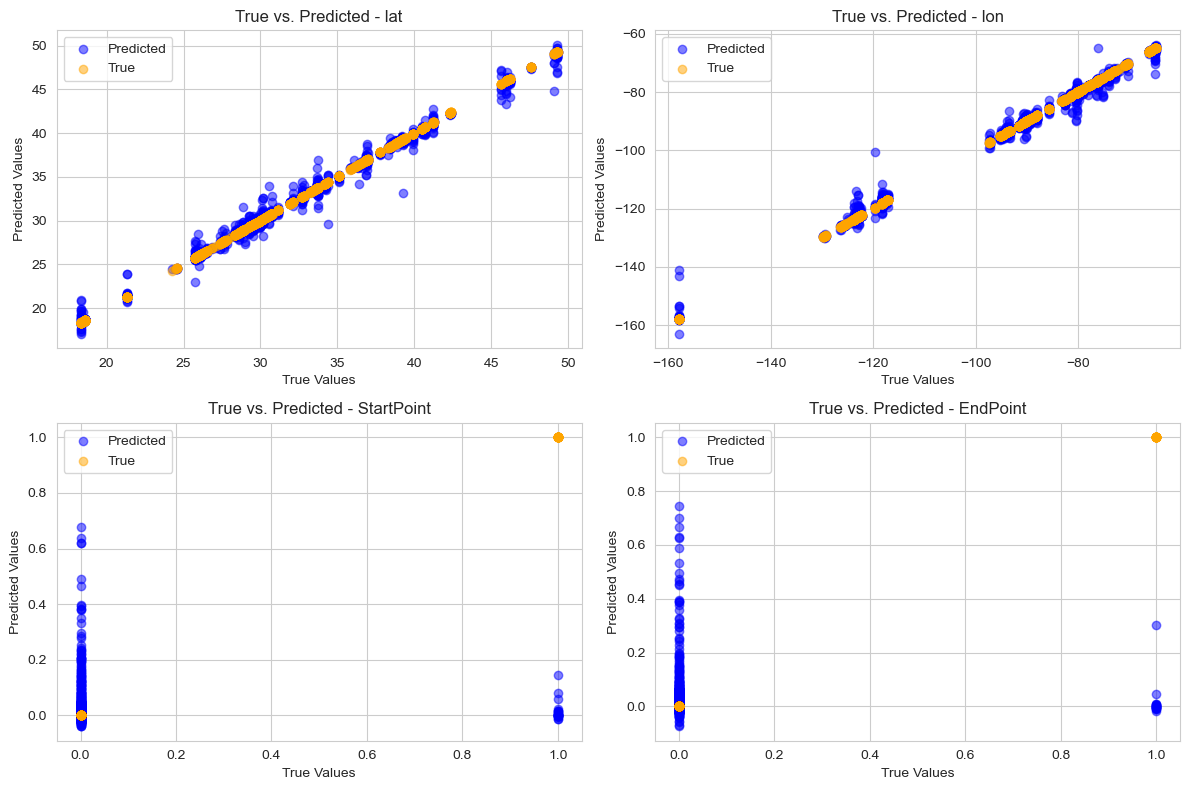

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with columns: lat, lon, time_diff, distance_km, speed_kmh, direction, StartPoint, EndPoint

# Data Preparation
X = df.drop(['lat', 'lon', 'StartPoint', 'EndPoint'], axis=1)
y = df[['lat', 'lon', 'StartPoint', 'EndPoint']]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = XGBRegressor()
model.fit(X_train, y_train)

# Prediction for Each Timestep
timesteps_predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, timesteps_predictions)
print(f'Mean Squared Error: {mse}')

# Scatter Plot of Results
plt.figure(figsize=(12, 8))

for i in range(4):  # Assuming there are four target variables (lat, lon, StartPoint, EndPoint)
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test.iloc[:, i], timesteps_predictions[:, i], alpha=0.5, label='Predicted', color='blue')
    plt.scatter(y_test.iloc[:, i], y_test.iloc[:, i], alpha=0.5, label='True', color='orange')
    plt.title(f'True vs. Predicted - {y.columns[i]}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df